In [176]:
pip install numpy pandas yfinance matplotlib plotly ipython nbformat

  Using cached nbformat-5.10.4-py3-none-any.whl.metadata (3.6 kB)
  Using cached attrs-25.4.0-py3-none-any.whl.metadata (10 kB)
Using cached nbformat-5.10.4-py3-none-any.whl (78 kB)
Using cached attrs-25.4.0-py3-none-any.whl (67 kB)

   ----------- ---------------------------- 2/7 [attrs]
   ----------- ---------------------------- 2/7 [attrs]
   ----------------- ---------------------- 3/7 [referencing]
   ---------------------------- ----------- 5/7 [jsonschema]
   ---------------------------- ----------- 5/7 [jsonschema]
   ---------------------------- ----------- 5/7 [jsonschema]
   ---------------------------------- ----- 6/7 [nbformat]
   ---------------------------------- ----- 6/7 [nbformat]
   ---------------------------------- ----- 6/7 [nbformat]
   ---------------------------------------- 7/7 [nbformat]

Note: you may need to restart the kernel to use updated packages.


In [158]:
import numpy as np
import pandas as pd
import yfinance as yf

In [159]:
goog = yf.Ticker("GOOG")
google_five_year_history = goog.history(period='5y')

Why this is a "Full Stack" Quant Project
np.random.normal & np.cumsum: You demonstrated you understand stochastic processes (random walks), which is the foundation of option pricing.

pd.date_range: You handled time-indexing, essential for time-series alignment.

rolling() & shift(): These are the two most frequently used Pandas functions in finance. You used shift() correctly to avoid Look-Ahead Bias, a critical error junior quants make.

np.where: You avoided slow Python loops for trade logic.

cummax(): You calculated Drawdown, which is the #1 metric risk managers look at (even more than returns).

In [160]:
google_five_year_history

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-02-16 00:00:00-05:00,104.434728,106.832743,104.434728,105.305199,22676000,0.0,0.0
2021-02-17 00:00:00-05:00,104.218347,105.888817,104.164748,105.623306,21418000,0.0,0.0
2021-02-18 00:00:00-05:00,104.733972,105.842904,104.402459,105.071938,22432000,0.0,0.0
2021-02-19 00:00:00-05:00,105.174679,105.733484,104.089813,104.274925,29148000,0.0,0.0
2021-02-22 00:00:00-05:00,102.580632,103.792543,102.339445,102.475426,27350000,0.0,0.0
...,...,...,...,...,...,...,...
2026-02-09 00:00:00-05:00,321.239990,327.739990,317.700012,324.399994,26103300,0.0,0.0
2026-02-10 00:00:00-05:00,320.910004,321.630005,314.660004,318.630005,25281900,0.0,0.0
2026-02-11 00:00:00-05:00,318.959991,321.045013,310.130005,311.329987,24008100,0.0,0.0


In [161]:
# Rolling Window Calculations (The bread and butter of Pandas)
window = 140 #20 week
google_five_year_history['SMA'] = google_five_year_history['Close'].rolling(window=window).mean()       # Simple Moving Average
google_five_year_history['Vol'] = google_five_year_history['Close'].std()        # Rolling Volatility

In [162]:
# Calculate Log Returns (Preferred in quant finance over simple returns)
# np.log -> Vectorized math function
# shift(1) -> Aligns today's price with yesterday's, as such you are able to calculate the log returns by alligning todays price with yesterdays price
google_five_year_history['Log_Ret'] = np.log(google_five_year_history['Close']/ google_five_year_history['Close'].shift(1))

In [163]:
# Vectorized Z-Score Calculation (NumPy Broadcasting)
# Logic: How many standard deviations is price away from the mean?
google_five_year_history['Z Score'] = (google_five_year_history['Close'] - google_five_year_history['SMA']) / google_five_year_history['Vol']

In [164]:
# np.where is faster than applying a function with if/else
# Strategy: Long (+1) if Z < -1 (Oversold), Short (-1) if Z > 1 (Overbought), else Flat (0)
google_five_year_history['Position'] = np.where(google_five_year_history['Z Score'] < -0.1, 1, 
                 np.where(google_five_year_history['Z Score'] > 0.1, -1, 0))

In [165]:
# --- 5. BACKTESTING: Alignment & Performance ---

# Look-ahead Bias Prevention: We must shift the position down by 1 day.
# We make the decision Today based on Today's close, so we earn returns Tomorrow.
google_five_year_history['Strategy_Ret'] = google_five_year_history['Position'].shift(1) * google_five_year_history['Log_Ret']

# Cumulative Returns (Equity Curve)
google_five_year_history['Cum_Ret'] = google_five_year_history['Strategy_Ret'].cumsum().apply(np.exp)

# Drawdown Calculation (Crucial Risk Metric)
# cummax() tracks the highest peak reached so far
running_max = google_five_year_history['Cum_Ret'].cummax()
google_five_year_history['Drawdown'] = (google_five_year_history['Cum_Ret'] - running_max) / running_max

In [166]:
display(google_five_year_history)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,SMA,Vol,Log_Ret,Z Score,Position,Strategy_Ret,Cum_Ret,Drawdown
Date,,,,,,,,,,,,,,,
2021-02-16 00:00:00-05:00,104.434728,106.832743,104.434728,105.305199,22676000,0.0,0.0,NaN,52.82833,NaN,NaN,0,NaN,NaN,NaN
2021-02-17 00:00:00-05:00,104.218347,105.888817,104.164748,105.623306,21418000,0.0,0.0,NaN,52.82833,0.003016,NaN,0,0.000000,1.000000,0.000000
2021-02-18 00:00:00-05:00,104.733972,105.842904,104.402459,105.071938,22432000,0.0,0.0,NaN,52.82833,-0.005234,NaN,0,-0.000000,1.000000,0.000000
2021-02-19 00:00:00-05:00,105.174679,105.733484,104.089813,104.274925,29148000,0.0,0.0,NaN,52.82833,-0.007614,NaN,0,-0.000000,1.000000,0.000000
2021-02-22 00:00:00-05:00,102.580632,103.792543,102.339445,102.475426,27350000,0.0,0.0,NaN,52.82833,-0.017408,NaN,0,-0.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-02-09 00:00:00-05:00,321.239990,327.739990,317.700012,324.399994,26103300,0.0,0.0,270.065001,52.82833,0.004015,1.028520,-1,-0.004015,0.694122,-0.441954
2026-02-10 00:00:00-05:00,320.910004,321.630005,314.660004,318.630005,25281900,0.0,0.0,270.970835,52.82833,-0.017947,0.902152,-1,0.017947,0.706692,-0.431849
2026-02-11 00:00:00-05:00,318.959991,321.045013,310.130005,311.329987,24008100,0.0,0.0,271.828805,52.82833,-0.023177,0.747727,-1,0.023177,0.723262,-0.418527


In [167]:
clean_df = google_five_year_history.dropna()

print(f"Final Portfolio Value: {clean_df['Cum_Ret'].iloc[-1]:.4f}")
print(f"Max Drawdown: {clean_df['Drawdown'].min():.2%}")
print(f"Sharpe Ratio: {(clean_df['Strategy_Ret'].mean() / clean_df['Strategy_Ret'].std()) * np.sqrt(252):.2f}")

# Check the first few rows to see the structure
print("\nData Snapshot:")
print(clean_df[['Close', 'SMA', 'Z Score', 'Position']].tail())

Final Portfolio Value: 0.7335
Max Drawdown: -47.51%
Sharpe Ratio: -0.24

Data Snapshot:
                                Close         SMA   Z Score  Position
Date                                                                 
2026-02-09 00:00:00-05:00  324.399994  270.065001  1.028520        -1
2026-02-10 00:00:00-05:00  318.630005  270.970835  0.902152        -1
2026-02-11 00:00:00-05:00  311.329987  271.828805  0.747727        -1
2026-02-12 00:00:00-05:00  309.369995  272.660722  0.694879        -1
2026-02-13 00:00:00-05:00  306.989990  273.469363  0.634520        -1


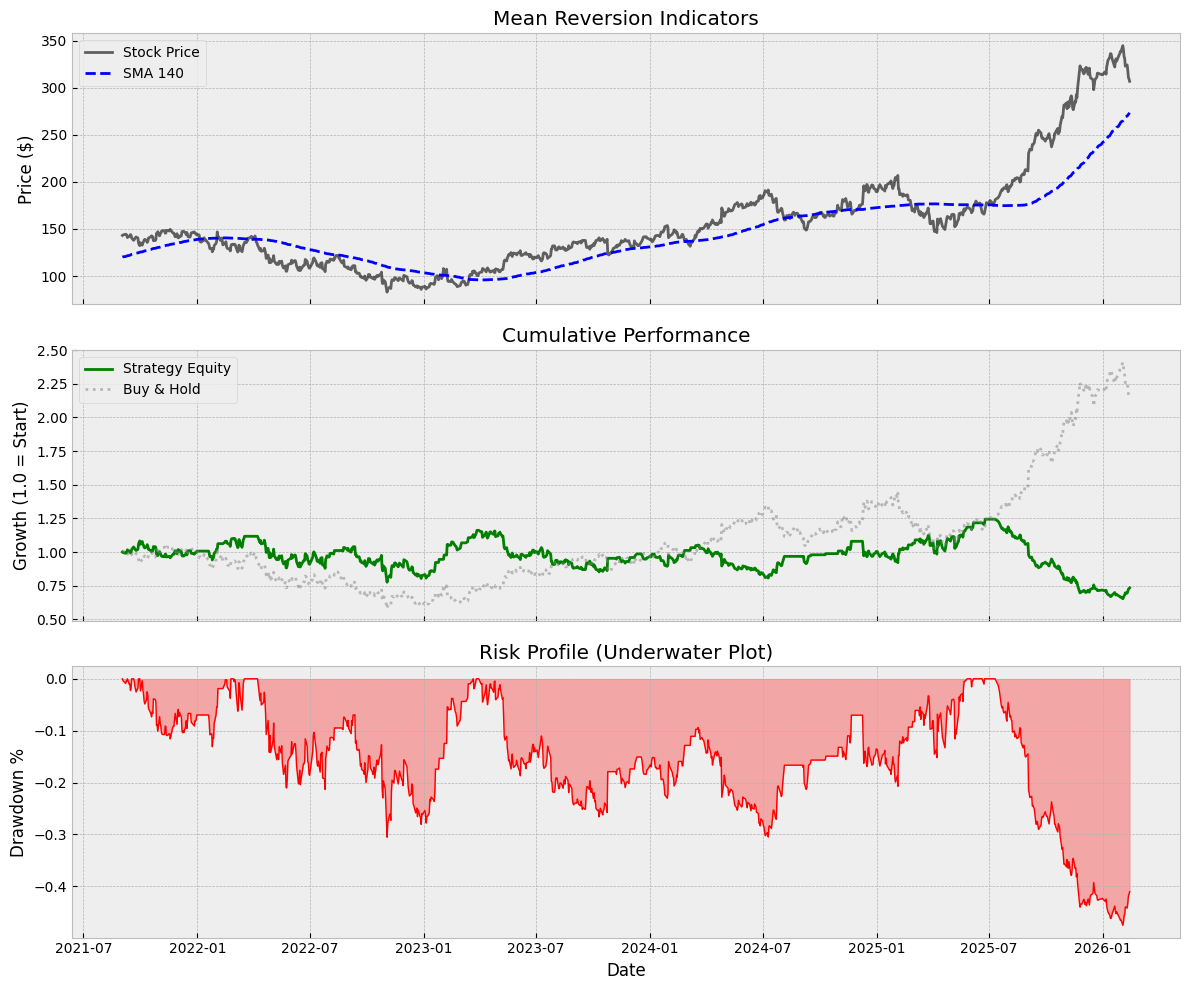

In [168]:
import matplotlib.pyplot as plt

# Use a clean style for financial charts
plt.style.use('bmh') 

# Create a figure with 3 rows, sharing the same Date (x-axis)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# --- CHART 1: Price vs. Moving Average ---
ax1.plot(clean_df.index, clean_df['Close'], label='Stock Price', color='black', alpha=0.6)
ax1.plot(clean_df.index, clean_df['SMA'], label=f'SMA {window}', color='blue', linestyle='--')
ax1.set_ylabel('Price ($)')
ax1.set_title('Mean Reversion Indicators')
ax1.legend(loc='upper left')

# --- CHART 2: Strategy vs. Buy & Hold (Performance) ---
# Calculate Buy & Hold returns for comparison
buy_and_hold = clean_df['Close'] / clean_df['Close'].iloc[0]

ax2.plot(clean_df.index, clean_df['Cum_Ret'], label='Strategy Equity', color='green', linewidth=2)
ax2.plot(clean_df.index, buy_and_hold, label='Buy & Hold', color='gray', linestyle=':', alpha=0.5)
ax2.set_ylabel('Growth (1.0 = Start)')
ax2.set_title('Cumulative Performance')
ax2.legend(loc='upper left')

# --- CHART 3: Drawdown (The "Underwater" Plot) ---
ax3.plot(clean_df.index, clean_df['Drawdown'], color='red', linewidth=1)
# Fill the area to emphasize the "pain"
ax3.fill_between(clean_df.index, clean_df['Drawdown'], 0, color='red', alpha=0.3)
ax3.set_ylabel('Drawdown %')
ax3.set_title('Risk Profile (Underwater Plot)')
ax3.set_xlabel('Date')

# Formatting to prevent label overlap
plt.tight_layout()
plt.show()

In [178]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create a subplot figure with 3 rows
# vertical_spacing=0.05 reduces the gap between charts
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, 
                    vertical_spacing=0.05,
                    subplot_titles=('Price & SMA', 'Cumulative Performance', 'Drawdown Risk'),
                    row_heights=[0.5, 0.3, 0.2]) # Give top chart most space

# --- CHART 1: Price vs. SMA (Candlestick style often preferred, but line is fine) ---
fig.add_trace(go.Scatter(x=clean_df.index, y=clean_df['Close'], 
                         mode='lines', name='Price', line=dict(color='black')), row=1, col=1)

fig.add_trace(go.Scatter(x=clean_df.index, y=clean_df['SMA'], 
                         mode='lines', name=f'SMA {window}', line=dict(color='blue', dash='dash')), row=1, col=1)

# Highlight Buy/Sell Signals (Optional but professional)
# Buy Signals (Green Triangles)
buys = clean_df[clean_df['Position'] == 1]
fig.add_trace(go.Scatter(x=buys.index, y=buys['Close'], 
                         mode='markers', name='Buy Signal', 
                         marker=dict(symbol='triangle-up', size=10, color='green')), row=1, col=1)

# Sell Signals (Red Triangles)
sells = clean_df[clean_df['Position'] == -1]
fig.add_trace(go.Scatter(x=sells.index, y=sells['Close'], 
                         mode='markers', name='Sell Signal', 
                         marker=dict(symbol='triangle-down', size=10, color='red')), row=1, col=1)


# --- CHART 2: Strategy vs. Buy & Hold ---
# Re-calculate Buy & Hold for context
buy_and_hold = clean_df['Close'] / clean_df['Close'].iloc[0]

fig.add_trace(go.Scatter(x=clean_df.index, y=clean_df['Cum_Ret'], 
                         mode='lines', name='Strategy Equity', line=dict(color='green', width=2)), row=2, col=1)

fig.add_trace(go.Scatter(x=clean_df.index, y=buy_and_hold, 
                         mode='lines', name='Buy & Hold', line=dict(color='gray', dash='dot')), row=2, col=1)


# --- CHART 3: Drawdown (The "Underwater" Plot) ---
fig.add_trace(go.Scatter(x=clean_df.index, y=clean_df['Drawdown'], 
                         mode='lines', name='Drawdown', line=dict(color='red', width=1),
                         fill='tozeroy'), row=3, col=1) # fill='tozeroy' fills area to 0 line

# --- FINAL LAYOUT POLISH ---
fig.update_layout(title_text="Mean Reversion Strategy Dashboard",
                  height=900,  # Tall enough to see detail
                  showlegend=True,
                  hovermode="x unified") # Shows all values for a specific date at once

# Hide range slider (often annoying on subplots)
fig.update_xaxes(rangeslider_visible=False)

fig.show(renderer='browser')